In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import glob

In [2]:
sns.set_theme()

## Charging Data

In [3]:
raw_data = pd.read_csv("./data/Electric_Vehicle_Charging_Station_Data.csv")

In [4]:
raw_data

,ObjectId2,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID
0,1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/1/2018 17:49,MDT,1/1/2018 19:52,MDT,2:03:02,2:02:44,6.504,2.732,0.816,Level 2,0
1,2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 8:52,MDT,1/2/2018 9:16,MDT,0:24:34,0:24:19,2.481,1.042,0.311,Level 2,1
2,3,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 21:11,MDT,1/3/2018 6:23,MDT,9:12:21,3:40:52,15.046,6.319,1.888,Level 2,2
3,4,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,1/3/2018 9:19,MDT,1/3/2018 11:14,MDT,1:54:51,1:54:29,6.947,2.918,0.872,Level 2,3
4,5,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,1/3/2018 14:13,MDT,1/3/2018 14:30,MDT,0:16:58,0:16:44,1.800,0.756,0.226,Level 2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70189,70190,MUNICIPAL SC / 1100WALNUT1,1100 Walnut,Boulder,Colorado,80302,2023-08-31 09:20:52,MDT,2023-08-31 10:56:11,MDT,01:35:13,00:49:39,2.360,1.675,0.296,Level 2,70125
70190,70191,MUNICIPAL SC / 1104 SPRUCE1,1100 Spruce St,Boulder,Colorado,80302,2023-08-31 09:24:16,MDT,2023-08-31 10:26:58,MDT,01:02:42,01:02:28,6.277,4.457,0.788,Level 2,70126
70191,70192,BOULDER / ATRIUM ST1,1770 13th St,Boulder,Colorado,80302,2023-08-31 09:39:36,MDT,2023-08-31 11:48:55,MDT,02:09:22,02:09:08,12.933,9.183,1.623,Level 2,70127
70192,70193,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2023-08-31 09:41:08,MDT,2023-08-31 10:55:27,MDT,01:14:21,01:14:09,7.512,5.334,0.943,Level 2,70128


In [5]:
raw_data.describe()

,ObjectId2,Zip_Postal_Code,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,ObjectID
count,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000
mean,35097.500000,80302.573724,8.450916,5.258133,1.060591,35096.500000
std,20263.406735,1.108910,8.807785,5.919214,1.105376,20263.406735
min,1.000000,80301.000000,0.000000,0.000000,0.000000,0.000000
25%,17549.250000,80302.000000,2.842250,1.597000,0.357000,17548.250000
50%,35097.500000,80302.000000,6.240000,3.676500,0.783000,35096.500000
75%,52645.750000,80303.000000,11.373000,6.851000,1.427000,52644.750000
max,70194.000000,80305.000000,92.691000,65.811000,11.633000,70193.000000


In [6]:
raw_data.columns

Index(['ObjectId2', 'Station_Name', 'Address', 'City', 'State_Province',
       'Zip_Postal_Code', 'Start_Date___Time', 'Start_Time_Zone',
       'End_Date___Time', 'End_Time_Zone', 'Total_Duration__hh_mm_ss_',
       'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'GHG_Savings__kg_',
       'Gasoline_Savings__gallons_', 'Port_Type', 'ObjectID'],
      dtype='object')

In [7]:
df = raw_data.copy()

# Convert your start and end times to datetime, ensuring correct timezone handling if necessary
df['Start_Date___Time'] = pd.to_datetime(df['Start_Date___Time'], format='mixed')
df['End_Date___Time'] = pd.to_datetime(df['End_Date___Time'], format='mixed')

df = df.dropna()

In [8]:
# Function to distribute charging session energy hourly
def distribute_energy_hourly(row):
    # Generate a date range for sec charged
    start = row['Start_Date___Time']
    end = row['End_Date___Time']
    sec = pd.date_range(start=start, end=end, freq='S')

    # calc total seconds charging
    total_sec = (row['End_Date___Time'] - row['Start_Date___Time']).total_seconds()

    # handle edge case of 0sec charging session
    if total_sec == 0:
        # print(f"zero seconds. Usage: {row['Energy__kWh_']}")
        return

    # calc charging rate (assuming constant charging rate over the time period)
    energy_per_sec = row['Energy__kWh_'] / total_sec
    sec_data = pd.DataFrame({'kW': energy_per_sec}, index=sec)

    # resample to hourly
    hourly_data = sec_data.resample('H').sum()
    
    return hourly_data

In [9]:
df.iloc[0]

ObjectId2                                          1
Station_Name                  BOULDER / JUNCTION ST1
Address                             2280 Junction Pl
City                                         Boulder
State_Province                              Colorado
Zip_Postal_Code                                80301
Start_Date___Time                2018-01-01 17:49:00
Start_Time_Zone                                  MDT
End_Date___Time                  2018-01-01 19:52:00
End_Time_Zone                                    MDT
Total_Duration__hh_mm_ss_                    2:03:02
Charging_Time__hh_mm_ss_                     2:02:44
Energy__kWh_                                   6.504
GHG_Savings__kg_                               2.732
Gasoline_Savings__gallons_                     0.816
Port_Type                                    Level 2
ObjectID                                           0
Name: 0, dtype: object

In [10]:
hourly_contributions = pd.concat([distribute_energy_hourly(row) for i, row in df.iterrows()])

In [11]:
hourly_demand = hourly_contributions.resample('H').sum()

demand_22 = hourly_demand[hourly_demand.index.year == 2022]
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'
complete_index = pd.date_range(start=start_date, end=end_date, freq='H')
demand_22 = demand_22.reindex(complete_index)
demand_22.fillna(0, inplace=True)

demand_22

,kW
2022-01-01 00:00:00,0.000000
2022-01-01 01:00:00,0.000000
2022-01-01 02:00:00,0.000000
2022-01-01 03:00:00,0.000000
2022-01-01 04:00:00,0.000000
...,...
2022-12-31 19:00:00,7.807573
2022-12-31 20:00:00,3.032536
2022-12-31 21:00:00,4.763091
2022-12-31 22:00:00,5.833388


## Exploratory Data Analysis (EDA)

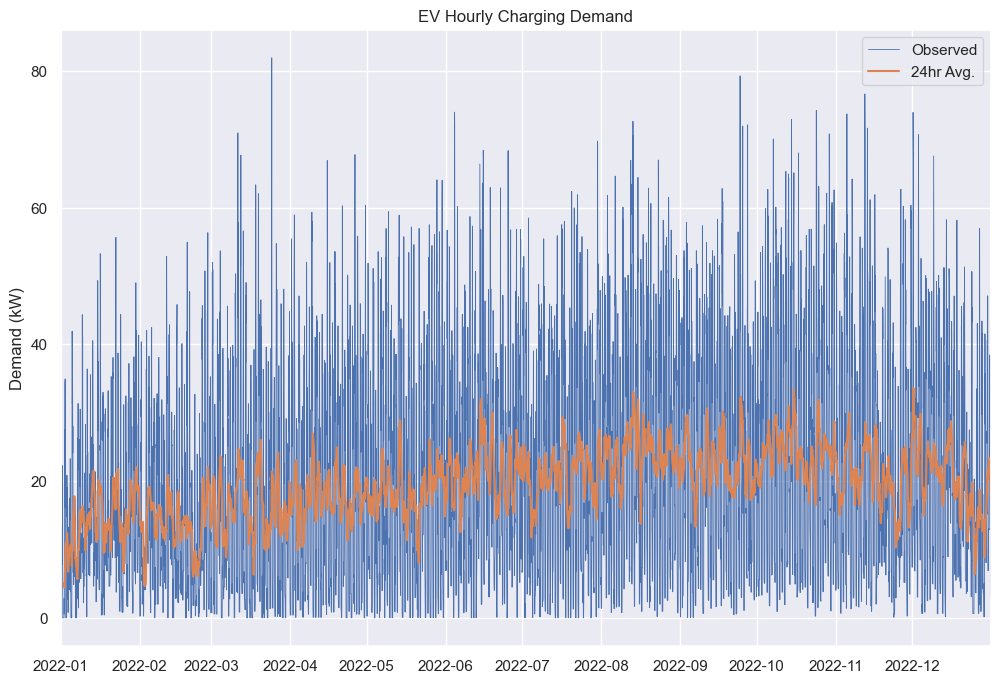

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(demand_22.index, demand_22.kW, linewidth=.6, label="Observed")

rolling_avg = demand_22.kW.rolling(24).mean()
ax.plot(demand_22.index, rolling_avg, label="24hr Avg.")

ax.set_title("EV Hourly Charging Demand")
ax.set_ylabel("Demand (kW)")
ax.set_xmargin(0)
ax.legend()

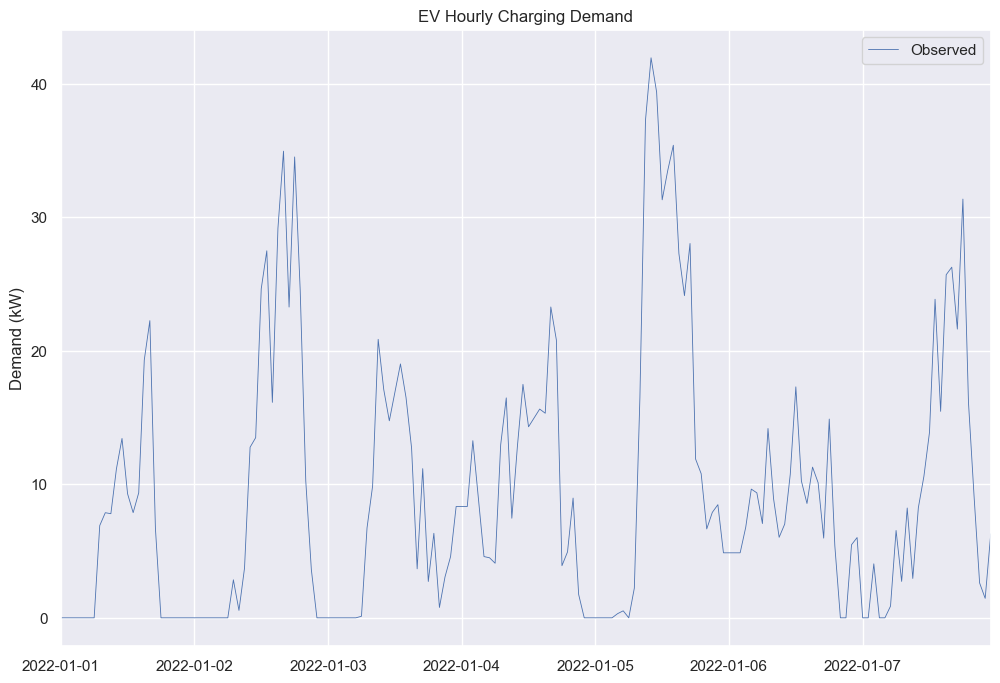

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

d22_week = demand_22.iloc[:24*7]

ax.plot(d22_week.index, d22_week.kW, linewidth=.6, label="Observed")

ax.set_title("EV Hourly Charging Demand")
ax.set_ylabel("Demand (kW)")
ax.set_xmargin(0)
ax.legend()

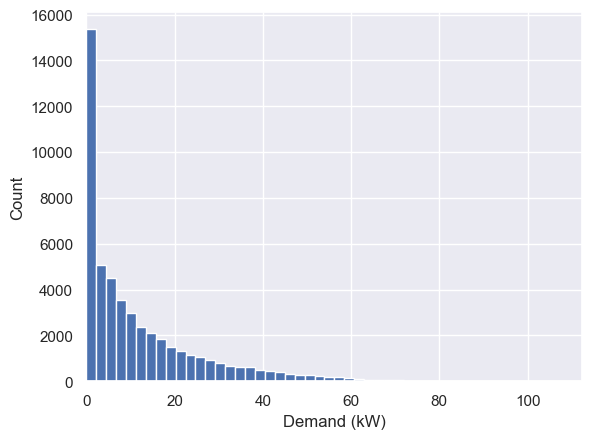

In [14]:
fig, ax = plt.subplots()

ax.hist(hourly_demand.kW, bins=50)

ax.set_ylabel("Count")
ax.set_xlabel("Demand (kW)")
ax.set_xmargin(0)

In [15]:
demand_22_MW = demand_22/1e3

demand_22_MW.to_csv("ev_demand_22.csv", header=False, index=False)